In [ ]:
using DrWatson
@quickactivate "APLG"
include(srcdir("pdes.jl"));
include(srcdir("plotting.jl"));
include(srcdir("travelling.jl"));
include(srcdir("phase_diag.jl"));
using SciPy

In [2]:
function add_TP(fig,ax; Pe = 7.5, font = 12)
    # Load data
    file_name = datadir("pm_pdes_pro/TP/Pe=$(Pe).jld2")
    data = load(file_name)
    @unpack outline = data

    # Create outline segments
    left_out = [x .+ [-0.005,0.005] for x in sort(outline[1:20]; by=x->x[2])]
    top_out = [[0.41,0.37], [0.42,0.37], [0.43,0.37], [0.44,0.37], [0.45,0.37]]
    right_out = [x .+ [0.005,0.005] for x in sort(outline[78:end]; by=x->x[1])]
    bottom_out = [x .- [0.00,0.005] for x in sort(outline[21:77]; by=x->x[1], rev=true)]

    # Combine segments into single array
    X = hcat(left_out..., top_out..., right_out..., bottom_out..., left_out[1])

    # Create and evaluate spline
    f, u = SciPy.interpolate.splprep(X, s=0.001, per=true)
    xint, yint = SciPy.interpolate.splev(0.:.001:1., f)

    # Plot outline
    ax.plot(xint, yint; color="purple", linestyle="--", label="T existence")

    # Fill between curves
    min_x = minimum(xint)
    max_x = maximum(xint)
    dx = (max_x - min_x)/500
    xs = min_x:dx:max_x

    g(t) = SciPy.interpolate.splev(t,f)[1][1]
    ts = hcat([find_zeros(y->(g(y)-x),(0,1)) for x in xs]...)

    h(t) = SciPy.interpolate.splev(t,f)[2][1]
    ax.fill_between(xs, h.(ts[1,:]), h.(ts[2,:]), color="purple", alpha=0.3, linewidth=0)

    # Add legend
    ax.legend(edgecolor="white", fontsize=font)
    return fig, ax
end

add_TP (generic function with 1 method)

In [3]:
function cp_param(i)
    DT, v0, DR, N, Δx, Lx, Ly, ϕa, ϕp, δt, δ = (1.0, 7.5, 1.0, 100, 0.05, 25.0, 0.5, 0.1,0.1,1e-5, 0.1);
    ϕa,ϕp = [(x,y) for x in 0.1:0.02:1.0, y in 0.0:0.01:0.4 if x+y<1][i]
    T, save_interval, param_name, pert = (2000.0, 10.0, "cp_experiment", "double")
    param = new_param(DT, v0, DR, N, Δx, Lx, Ly, ϕa, ϕp, δt, δ; T = T, name = param_name, save_interval = save_interval, save_on = true, pert= pert)
    return param
end
function cp_param_coord(ϕa,ϕp)
    DT, v0, DR, N, Δx, Lx, Ly, _, _, δt, δ = (1.0, 7.5, 1.0, 100, 0.05, 25.0, 0.5, 0.1,0.1,1e-5, 0.1);
    T, save_interval, param_name, pert = (2000.0, 10.0, "cp_experiment", "double")
    param = new_param(DT, v0, DR, N, Δx, Lx, Ly, ϕa, ϕp, δt, δ; T = T, name = param_name, save_interval = save_interval, save_on = true, pert= pert)
    return param
end
nmax, cmax, dcmax = 0, 0, 0
function f_dots(param, fs)
    nmax, cmax, dcmax = 0, 0, 0
    for f in fs
        normf, c, dc = f_dot(param, f)
        nmax, cmax, dcmax = max(normf,nmax), max(abs(c),cmax), max(abs(dc),dcmax)
        # println(c)
    end
    return nmax, cmax, dcmax
end
function tp_param(i)
    DT, v0, DR, N, Δx, Lx, Ly, ϕa, ϕp, δt, δ = (1.0, 7.5, 1.0, 100, 0.05, 25.0, 0.5, 0.1,0.1,1e-5, 0.1);
    ϕa,ϕp = [(x,y) for x in 0.1:0.02:1.0, y in 0.0:0.01:0.4 if x+y<1][i]
    T, save_interval, param_name, pert = (2000.0, 10.0, "tp_experiment", "single")
    param = new_param(DT, v0, DR, N, Δx, Lx, Ly, ϕa, ϕp, δt, δ; T = T, name = param_name, save_interval = save_interval, save_on = true, pert= pert)
    return param
end
function tp_param_coord(ϕa,ϕp)
    DT, v0, DR, N, Δx, Lx, Ly, _, _, δt, δ = (1.0, 7.5, 1.0, 100, 0.05, 25.0, 0.5, 0.1,0.1,1e-5, 0.1);
    T, save_interval, param_name, pert = (2000.0, 10.0, "tp_experiment", "single")
    param = new_param(DT, v0, DR, N, Δx, Lx, Ly, ϕa, ϕp, δt, δ; T = T, name = param_name, save_interval = save_interval, save_on = true, pert= pert)
    return param
end
mdiff(f) = abs(maximum(f[:,2]-f[:,1])+minimum(f[:,2]-f[:,1]))/maximum(abs.(f[:,2]-f[:,1]))
mdiffs(fs) = minimum(mdiff.(fs[end:-1:(end-10)]))

# length of the grid for both cp and tp
N = length([(x,y) for x in 0.1:0.02:1.0, y in 0.0:0.01:0.4 if x+y<1]);

In [4]:
Pe = 7.5

data = load(datadir("pm_pdes_pro/tp_data/Pe=$(Pe).jld2"))
tp_data = data["tp_data"];
data = load(datadir("pm_pdes_pro/cp_data/Pe=$(Pe).jld2"))
cp_data = data["cp_data"];

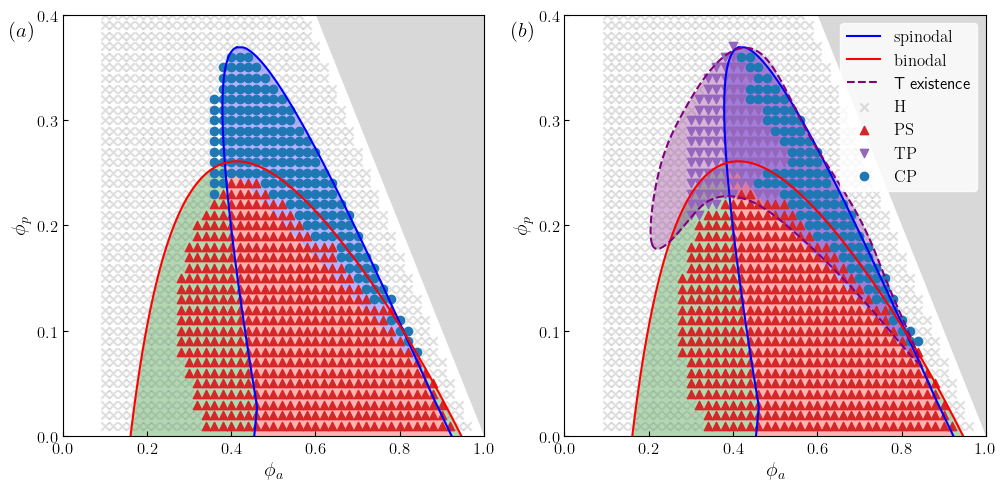

PyObject Text(-0.125, 0.95, '$(b)$')

In [5]:
# plot cp
rc("text", usetex=true)
fig, axs = subplots(1,2,figsize=(10,5))
ax = axs[1]
ts = ones(1);
plot_phase_reduced(fig, ax, Pe, 12; Δϕ = 0.001, plot_tieline = false)
# values of the thresholds to classify the points
ϵ1 = 5e-2
ϵ2 = 8e-3
ϵ3 = 9e-1
ϵ4 = 1e-5
ϵ5 = 8e-3

missingcp_i = []
cp_pts = Dict{String, Any}()
# for i in 46:1:N
# skip the first 45 points (corresponding to phi_p = 0)
for i in 46:N
    param = cp_param(i)
    @unpack ϕa, ϕp = param
    if "$(i)" in keys(cp_data)
        if ϕa+ϕp<0.98
            normf, c, dm, ts[end],dc = cp_data["$(i)"]
            if (normf < ϵ1)
                cp_pts["$(i)"] = "H"
                ax.scatter(ϕa, ϕp; marker = "x", label = "_homog", color = "grey", alpha = 0.25)
            elseif (c < ϵ2)&&(ts[end]>700)
                cp_pts["$(i)"] = "PS"
                ax.scatter(ϕa, ϕp; marker = "^", label = "_PS", color = "tab:red")
            elseif (c > ϵ2)&&(dc < ϵ4)&&(ts[end]>700)
                cp_pts["$(i)"] = "TP"
                ax.scatter(ϕa, ϕp; marker = "v", label = "_TP", color = "tab:purple")
            elseif (c > ϵ5)&&(ts[end]>700)
                cp_pts["$(i)"] = "CP"
                ax.scatter(ϕa, ϕp; marker = "o", label = "_CP", color = "tab:blue")
            else
                push!(missingcp_i, i)
                println("case cp i = $(i) does not satisfy any of the classification conditions")
            end
        end
    else
        push!(missingcp_i, i)
    end
end
ax.scatter(-1, -1; marker = "x", label = L"\mathrm{H}", color = "grey", alpha = 0.25)
ax.scatter(-1, -1; marker = "^", label = L"\mathrm{PS}", color = "tab:red")
# ax.scatter(-1, -1; marker = "*", label = L"\mathrm{TP}", color = "tab:purple")
ax.scatter(-1, -1; marker = "o", label = L"\mathrm{CP}", color = "tab:blue")
ax.get_legend().remove()
# display(fig)
#
ax = axs[2]
v0 = 7.5
plot_phase_reduced(fig, ax, param["v0"], 12; Δϕ = 0.001, plot_tieline = false)
add_TP(fig,ax; Pe = 7.5) 
missingtp_i = []
tp_pts = Dict{String, Any}()
# skip the first 45 points (corresponding to phi_p = 0)
for i in 46:N
    param = tp_param(i)
    @unpack ϕa, ϕp = param
    if "$(i)" in keys(tp_data)
        if ϕa+ϕp<0.98
            normf, c, dm, ts[end],dc = tp_data["$(i)"]
            if (normf < ϵ1)
                tp_pts["$(i)"] = "H"
                ax.scatter(ϕa, ϕp; marker = "x", label = "_homog", color = "grey", alpha = 0.25)
            elseif (c < ϵ2)&&(ts[end]>700)
                tp_pts["$(i)"] = "PS"
                ax.scatter(ϕa, ϕp; marker = "^", label = "_PS", color = "tab:red")
            elseif (c > ϵ2)&&(dc < ϵ4)&&(ts[end]>700)
                tp_pts["$(i)"] = "TP"
                ax.scatter(ϕa, ϕp; marker = "v", label = "_TP", color = "tab:purple")
            elseif (c > ϵ5)&&(ts[end]>700)
                tp_pts["$(i)"] = "CP"
                ax.scatter(ϕa, ϕp; marker = "o", label = "_CP", color = "tab:blue")
            else
                push!(missingtp_i, i); 
                println("case tp i = $(i) does not satisfy any of the classification conditions")
            end
        end
    else
        push!(missingtp_i, i)
    end
end
ax.scatter(-1, -1; marker = "x", label = L"\mathrm{H}", color = "grey", alpha = 0.25)
ax.scatter(-1, -1; marker = "^", label = L"\mathrm{PS}", color = "tab:red")
ax.scatter(-1, -1; marker = "v", label = L"\mathrm{TP}", color = "tab:purple")
ax.scatter(-1, -1; marker = "o", label = L"\mathrm{CP}", color = "tab:blue")
ax.legend(edgecolor = "white", fontsize=12)
font = 15
axs[1].annotate(L"(a)", (-0.125, 0.95), xycoords = "axes fraction", rotation = 0, fontsize = font )
axs[2].annotate(L"(b)", (-0.125, 0.95), xycoords = "axes fraction", rotation = 0, fontsize = font )



In [6]:
file_name = datadir("pm_pdes_pro/tp_pts/Pe=$(Pe).jld2")
data = Dict{String,Any}()
@pack! data = tp_pts
safesave(file_name,data)

file_name = datadir("pm_pdes_pro/cp_pts/Pe=$(Pe).jld2")
data = Dict{String,Any}()
@pack! data = cp_pts
safesave(file_name,data)